In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')

train = pd.read_csv('application_train.csv', delimiter=',')
test = pd.read_csv('application_test.csv', delimiter=',')

new_train_X = train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                      'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE']]
new_test = test[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                      'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE']]

In [3]:
encoder = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
new_train_X.loc[:,'ORGANIZATION_TYPE'] = encoder.fit_transform(new_train_X['ORGANIZATION_TYPE'].fillna('').to_numpy().reshape(-1, 1))
new_test.loc[:,'ORGANIZATION_TYPE'] = encoder.transform(new_test['ORGANIZATION_TYPE'].fillna('').to_numpy().reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [4]:
new_train_X.fillna(0, inplace = True)
new_test.fillna(0, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [5]:
param1 = {
    'booster' : 'gblinear', #type of model
    'lambda': 0,  # L2 reg
    'alpha': 0, #L1 reg
    'verbosity': 2, #INFO
    'feature_selector': 'cyclic',  # Feature selection and ordering method
    'objective': 'binary:logistic',  # objective function (in this case for binary classification task)
    'eval_metric': 'aucpr'}
param2 = {
    'max_depth': 5,  # max tree depth
    'eta': 0.3,  # learning rate / step size
    'eval_metric': 'aucpr',
    'lambda' : 1,
    'verbosity': 1}#INFO
params_rf = {
    'colsample_bynode': 0.8,
    'learning_rate': 1,
    'max_depth': 5,
    'num_parallel_tree': 60,
    'objective': 'binary:logistic',
    'subsample': 0.8,
    'eval_metric': 'aucpr',
    'tree_method': 'gpu_hist'
}
params_rf2 = {
    'colsample_bynode': 0.7,
    'learning_rate': 1,
    'max_depth': 3,
    'eval_metric': 'aucpr',
    'num_parallel_tree': 60,
    'objective': 'binary:logistic',
    'subsample': 0.8,
    'lambda' : 0.7,
    'tree_method': 'gpu_hist'
}

In [37]:
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
estimators = [
     ('gradboosting1', xgb.XGBClassifier(n_estimators = 20, booster = 'gblinear', reg_lambda = 0, objective = 'binary:logistic', eval_metric = 'aucpr')),
     ('gradboosting2', xgb.XGBClassifier(n_estimators = 20, max_depth = 5, eta = 0.3, eval_metric = 'aucpr', reg_lambda = 1)),
     ('rf1', xgb.XGBClassifier(n_estimators = 20, colsample_bynode = 0.8, learning_rate = 1, max_depth = 5, 
                               num_parallel_tree = 60, objective = 'binary:logistic', subsample = 0.8, eval_metric = 'aucpr', tree_method = 'gpu_hist')),
     ('rf2', xgb.XGBClassifier(n_estimators = 20, colsample_bynode = 0.7, learning_rate = 1, max_depth = 3, reg_lambda = 0.7, 
                               num_parallel_tree = 60, objective = 'binary:logistic', subsample = 0.8, eval_metric = 'aucpr', tree_method = 'gpu_hist')),
     ('logreg', make_pipeline(StandardScaler(),
                          LogisticRegression(class_weight = 'balanced', solver='sag', tol=1e-4, max_iter=5000, random_state=0, C = 1)
                             )
     )
]

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_train_X, train.TARGET, test_size=0.35, shuffle = True)

In [39]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs = -1)
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('gradboosting1',
                                XGBClassifier(booster='gblinear',
                                              eval_metric='aucpr',
                                              n_estimators=20, reg_lambda=0)),
                               ('gradboosting2',
                                XGBClassifier(eta=0.3, eval_metric='aucpr',
                                              max_depth=5, n_estimators=20)),
                               ('rf1',
                                XGBClassifier(colsample_bynode=0.8,
                                              eval_metric='aucpr',
                                              learning_rate=1, max_depth=5,
                                              n_estimators=20,
                                              num_parallel_tree=60,
                                              su...
                                              eval_metric='aucpr',
                                    

In [40]:
clf.score(X_test, y_test)

0.9187114996887455

In [21]:
prob = clf.predict_proba(new_test)[:,1]
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['TARGET']= prob
sample_submission.to_csv('stacking.csv', index = False)

In [41]:
from sklearn.linear_model import LogisticRegressionCV
estimators = [
     ('gradboosting1', xgb.XGBClassifier(n_estimators = 10, booster = 'gblinear', reg_lambda = 0, objective = 'binary:logistic', eval_metric = 'aucpr')),
     ('gradboosting2', xgb.XGBClassifier(n_estimators = 40, max_depth = 5, eta = 0.3, eval_metric = 'aucpr', reg_lambda = 1.5, objective = 'binary:logistic')),
     ('rf1', xgb.XGBClassifier(n_estimators = 15, colsample_bynode = 0.8, learning_rate = 1, max_depth = 5, 
                               num_parallel_tree = 60, objective = 'binary:logistic', subsample = 0.8, eval_metric = 'aucpr', tree_method = 'gpu_hist')),
     ('rf2', xgb.XGBClassifier(n_estimators = 30, colsample_bynode = 0.7, learning_rate = 1, max_depth = 3, reg_lambda = 0.7, 
                               num_parallel_tree = 60, objective = 'binary:logistic', subsample = 0.8, eval_metric = 'aucpr', tree_method = 'gpu_hist')),
     ('logreg', make_pipeline(StandardScaler(),
                          LogisticRegressionCV(class_weight = 'balanced', scoring = 'roc_auc', solver='sag', tol=1e-4, max_iter=5000, random_state=0)
                             )
     )
]

In [42]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV(scoring = 'roc_auc'), n_jobs = -1)
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('gradboosting1',
                                XGBClassifier(booster='gblinear',
                                              eval_metric='aucpr',
                                              n_estimators=10, reg_lambda=0)),
                               ('gradboosting2',
                                XGBClassifier(eta=0.3, eval_metric='aucpr',
                                              max_depth=5, n_estimators=40,
                                              reg_lambda=1.5)),
                               ('rf1',
                                XGBClassifier(colsample_bynode=0.8,
                                              eval_metric='aucpr',
                                              learning_rate=1, max_depth=5,
                                              n_estimators=15,
                                              num_para...
                                              learning_rate=1, n_estimators=30,
                       

In [43]:
clf.score(X_test, y_test)

0.9187765379219356

In [52]:
pip install pip install scikit-plot

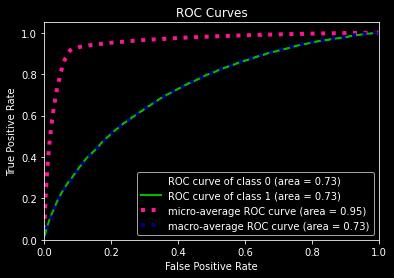

In [53]:
import scikitplot
scikitplot.metrics.plot_roc(y_test, clf.predict_proba(X_test))

Тут мы получили существенный результат

In [27]:
prob = clf.predict_proba(new_test)[:,1]
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['TARGET']= prob
sample_submission.to_csv('stacking2.csv', index = False)

In [44]:
print("gradboosting1 score ", clf.named_estimators_['gradboosting1'].score(X_test, y_test))
print("gradboosting2 score", clf.named_estimators_['gradboosting2'].score(X_test, y_test))
print("rf 1 score", clf.named_estimators_['rf1'].score(X_test, y_test))
print("rf 2 score", clf.named_estimators_['rf2'].score(X_test, y_test))
print("logreg score", clf.named_estimators_['logreg'].score(X_test, y_test))

gradboosting1 score  0.919361882020645
gradboosting2 score 0.9194176290776649
rf 1 score 0.919315426139795
rf 2 score 0.919324717315965
logreg score 0.7016291268015744


На лидер борде скор тоже возрос до 0.71105

теперь выкинем gradboosting2 и посмотрим, как изменится результат.

In [45]:
estimators2 = [
     ('gradboosting1', xgb.XGBClassifier(n_estimators = 10, booster = 'gblinear', reg_lambda = 0, objective = 'binary:logistic', eval_metric = 'aucpr')),
     ('rf1', xgb.XGBClassifier(n_estimators = 15, colsample_bynode = 0.8, learning_rate = 1, max_depth = 5, 
                               num_parallel_tree = 60, objective = 'binary:logistic', subsample = 0.8, eval_metric = 'aucpr', tree_method = 'gpu_hist')),
     ('rf2', xgb.XGBClassifier(n_estimators = 30, colsample_bynode = 0.7, learning_rate = 1, max_depth = 3, reg_lambda = 0.7, 
                               num_parallel_tree = 60, objective = 'binary:logistic', subsample = 0.8, eval_metric = 'aucpr', tree_method = 'gpu_hist')),
     ('logreg', make_pipeline(StandardScaler(),
                          LogisticRegressionCV(class_weight = 'balanced', scoring = 'roc_auc', solver='sag', tol=1e-4, max_iter=5000, random_state=0)
                             )
     )
]

In [46]:
clf2 = StackingClassifier(estimators=estimators2, final_estimator=LogisticRegressionCV(scoring = 'roc_auc'), n_jobs = -1)
clf2.fit(X_train, y_train)

StackingClassifier(estimators=[('gradboosting1',
                                XGBClassifier(booster='gblinear',
                                              eval_metric='aucpr',
                                              n_estimators=10, reg_lambda=0)),
                               ('rf1',
                                XGBClassifier(colsample_bynode=0.8,
                                              eval_metric='aucpr',
                                              learning_rate=1, max_depth=5,
                                              n_estimators=15,
                                              num_parallel_tree=60,
                                              subsample=0.8,
                                              tree_method='gpu_hist')),
                               ('rf2',
                                XGBClassifier(colsample_bynode=0.7,
                                              eval_metri...
                                              learning_rat

In [47]:
clf2.score(X_test, y_test)

0.9186836261602356

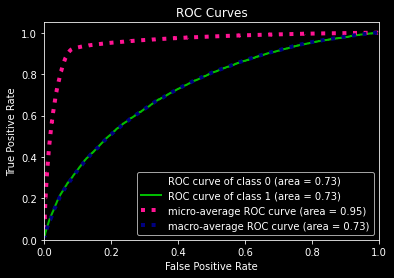

In [54]:
scikitplot.metrics.plot_roc(y_test, clf2.predict_proba(X_test))

In [48]:
prob = clf.predict_proba(new_test)[:,1]
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['TARGET']= prob
sample_submission.to_csv('stacking3.csv', index = False)

Скор на лидерборде у нас повысился и стал 0.71116, при том, что на валидации он повысился, значит мы чуть меньше переобучились.

В целом стекинг помог нам еще сильнее улучшить результат по сравнению со бустингом, однако наша модель стала сильнее переобучаться